In [1]:
from brats_data_loader import get_list_of_patients, get_train_transform, iterate_through_patients, BRATSDataLoader
from train_test_function import ModelTrainer
from jonas_net import AlbuNet3D34

from batchgenerators.utilities.data_splitting import get_split_deterministic
from batchgenerators.dataloading import MultiThreadedAugmenter

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
patients = get_list_of_patients('brats_data_preprocessed/Brats19TrainingData')
batch_size = 24 # 24
patch_size = [24, 128, 128]
in_channels = ['t1c', 't2', 'flair']

In [4]:
# num_splits=5 means 1/5th is validation data!
patients_train, patients_val = get_split_deterministic(patients, fold=0, num_splits=5, random_state=12345)

In [5]:
patients_test = get_list_of_patients('brats_data_preprocessed/Brats18ValidationData')

In [6]:
train_dl = BRATSDataLoader(
    patients_train,
    batch_size=batch_size,
    patch_size=patch_size,
    in_channels=in_channels
)

val_dl = BRATSDataLoader(
    patients_val,
    batch_size=batch_size,
    patch_size=patch_size,
    in_channels=in_channels
)

In [7]:
tr_transforms = get_train_transform(patch_size)

In [8]:
# finally we can create multithreaded transforms that we can actually use for training
# we don't pin memory here because this is pytorch specific.
tr_gen = MultiThreadedAugmenter(train_dl, tr_transforms, num_processes=4, # tr_transforms
                                num_cached_per_queue=3,
                                seeds=None, pin_memory=False)
# we need less processes for vlaidation because we dont apply transformations
val_gen = MultiThreadedAugmenter(val_dl, None,
                                 num_processes=max(1, 4 // 2),
                                 num_cached_per_queue=1,
                                 seeds=None,
                                 pin_memory=False)

In [9]:
tr_gen.restart()
val_gen.restart()

## Start Training

In [39]:
A = torch.ones(2,2)

In [40]:
A[1,1] = 2

In [42]:
A[0,0] = 3

In [43]:
A

tensor([[3., 1.],
        [1., 2.]])

In [44]:
(A == 1) | (A == 3)

tensor([[1, 1],
        [1, 0]], dtype=torch.uint8)

In [10]:
def dice(outputs, targets):

    # try without sigmoid
    # outputs = F.sigmoid(outputs)
    outputs = (outputs>0).float()
    smooth = 1e-15

    targets = ((targets == 1) | (targets == 3)).float()
    union_fg = (outputs+targets).sum() + smooth
    intersection_fg = (outputs*targets).sum() + smooth

    dice = 2 * intersection_fg / union_fg

    return dice

In [11]:
# Differentiable version of the dice metric
class SimpleDiceLoss():
    def __call__(self, outputs, targets):

        # try without sigmoid
        # outputs = F.sigmoid(outputs)
        outputs = torch.sigmoid(outputs)
        # outputs = (outputs>0).float()
        smooth = 1e-15
        
        targets = ((targets == 1) | (targets == 3)).float()
        union_fg = (outputs+targets).sum() + smooth
        intersection_fg = (outputs*targets).sum() + smooth
        
        dice = 2 * intersection_fg / union_fg

        return 1 - dice

In [12]:
net_3d = AlbuNet3D34(pretrained=True, is_deconv=True)

In [13]:
# before we went from 1e-2 to 1e-1
# wang uses 1e-3, isensee uses 1e-4*5 and decays it 0.985 every epoch, original albunet goes from 1e-3 to 1e-4
# wang uses 1e-7 weight decay, isensee 1e-5
# optimizer = optim.Adam(net_3d.parameters(), lr=1e-2, weight_decay=1e-6)

In [13]:
1e-4

0.0001

In [13]:
model_trainer = ModelTrainer('jonas_net_3d', net_3d, tr_gen, val_gen, SimpleDiceLoss(), dice,
                             lr=1e-4, epochs=100,
                             num_batches_per_epoch=100, num_validation_batches_per_epoch=100, use_gpu=True)

In [14]:
# with proposed augmentations
# pretrained
# lr=0.0001, epochs=50, num_batches_per_epoch=100, num_validation_batches_per_epoch=100
# ~4.5 hrs
# batch_size = 24, patch_size = [24, 128, 128]
model_trainer.run()
model_trainer.save_model('models/pr_augm_lr_0001_epochs_100_bs_24.pt')

[Val] Avg. Loss: 0.96, Avg. Metric: 0.04

# Epoch 1 #

[Train] Avg. Loss: 0.95, Avg. Metric: 0.05
[Val] Avg. Loss: 0.92, Avg. Metric: 0.07

# Epoch 2 #

[Train] Avg. Loss: 0.93, Avg. Metric: 0.08
[Val] Avg. Loss: 0.92, Avg. Metric: 0.13

# Epoch 3 #

[Train] Avg. Loss: 0.93, Avg. Metric: 0.18
[Val] Avg. Loss: 0.91, Avg. Metric: 0.27

# Epoch 4 #

[Train] Avg. Loss: 0.93, Avg. Metric: 0.26
[Val] Avg. Loss: 0.91, Avg. Metric: 0.46

# Epoch 5 #

[Train] Avg. Loss: 0.93, Avg. Metric: 0.52
[Val] Avg. Loss: 0.90, Avg. Metric: 0.64

# Epoch 6 #

[Train] Avg. Loss: 0.93, Avg. Metric: 0.61
[Val] Avg. Loss: 0.90, Avg. Metric: 0.53

# Epoch 7 #

[Train] Avg. Loss: 0.92, Avg. Metric: 0.66
[Val] Avg. Loss: 0.90, Avg. Metric: 0.69

# Epoch 8 #

[Train] Avg. Loss: 0.91, Avg. Metric: 0.65
[Val] Avg. Loss: 0.90, Avg. Metric: 0.72

# Epoch 9 #

[Train] Avg. Loss: 0.91, Avg. Metric: 0.67
[Val] Avg. Loss: 0.89, Avg. Metric: 0.72

# Epoch 10 #

[Train] Avg. Loss: 0.90, Avg. Metric: 0.69
[Val] Avg. Loss: 0.

In [13]:
# without proposed augmentations
# pretrained
# lr=0.001, epochs=50, num_batches_per_epoch=100, num_validation_batches_per_epoch=100
# ~4.5 hrs
# batch_size = 24, patch_size = [24, 128, 128]
model_trainer.run()

[Val] Avg. Loss: 0.98, Avg. Metric: 0.00

# Epoch 1 #

[Train] Avg. Loss: 0.95, Avg. Metric: 0.27
[Val] Avg. Loss: 0.94, Avg. Metric: 0.26

# Epoch 2 #

[Train] Avg. Loss: 0.93, Avg. Metric: 0.33
[Val] Avg. Loss: 0.92, Avg. Metric: 0.45

# Epoch 3 #

[Train] Avg. Loss: 0.86, Avg. Metric: 0.43
[Val] Avg. Loss: 0.79, Avg. Metric: 0.47

# Epoch 4 #

[Train] Avg. Loss: 0.69, Avg. Metric: 0.54
[Val] Avg. Loss: 0.67, Avg. Metric: 0.50

# Epoch 5 #

[Train] Avg. Loss: 0.47, Avg. Metric: 0.64
[Val] Avg. Loss: 0.41, Avg. Metric: 0.64

# Epoch 6 #

[Train] Avg. Loss: 0.37, Avg. Metric: 0.68
[Val] Avg. Loss: 0.39, Avg. Metric: 0.64

# Epoch 7 #

[Train] Avg. Loss: 0.31, Avg. Metric: 0.72
[Val] Avg. Loss: 0.40, Avg. Metric: 0.62

# Epoch 8 #

[Train] Avg. Loss: 0.29, Avg. Metric: 0.73
[Val] Avg. Loss: 0.41, Avg. Metric: 0.61

# Epoch 9 #

[Train] Avg. Loss: 0.26, Avg. Metric: 0.75
[Val] Avg. Loss: 0.35, Avg. Metric: 0.66

# Epoch 10 #

[Train] Avg. Loss: 0.24, Avg. Metric: 0.77
[Val] Avg. Loss: 0.

28035.21858549118

In [21]:
# with proposed augmentations
# pretrained
# lr=0.001, epochs=50, num_batches_per_epoch=100, num_validation_batches_per_epoch=100
# ~4.5 hrs
# batch_size = 24, patch_size = [24, 128, 128]
model_trainer.run()
model_trainer.save_model('models/pr_augm_lr_001_epochs_50_bs_24.pt')

[Val] Avg. Loss: 0.98, Avg. Metric: 0.02

# Epoch 1 #

[Train] Avg. Loss: 0.96, Avg. Metric: 0.23
[Val] Avg. Loss: 0.94, Avg. Metric: 0.25

# Epoch 2 #

[Train] Avg. Loss: 0.92, Avg. Metric: 0.31
[Train] Avg. Loss: 0.78, Avg. Metric: 0.45
[Val] Avg. Loss: 0.74, Avg. Metric: 0.33

# Epoch 4 #

[Train] Avg. Loss: 0.54, Avg. Metric: 0.56
[Val] Avg. Loss: 0.50, Avg. Metric: 0.55

# Epoch 5 #

[Train] Avg. Loss: 0.43, Avg. Metric: 0.60
[Val] Avg. Loss: 0.47, Avg. Metric: 0.54

# Epoch 6 #

[Train] Avg. Loss: 0.36, Avg. Metric: 0.66
[Val] Avg. Loss: 0.34, Avg. Metric: 0.68

# Epoch 7 #

[Train] Avg. Loss: 0.35, Avg. Metric: 0.66
[Val] Avg. Loss: 0.39, Avg. Metric: 0.63

# Epoch 8 #

[Train] Avg. Loss: 0.34, Avg. Metric: 0.67
[Val] Avg. Loss: 0.39, Avg. Metric: 0.62

# Epoch 9 #

[Train] Avg. Loss: 0.31, Avg. Metric: 0.69
[Val] Avg. Loss: 0.35, Avg. Metric: 0.66

# Epoch 10 #

[Train] Avg. Loss: 0.33, Avg. Metric: 0.68
[Val] Avg. Loss: 0.37, Avg. Metric: 0.64

# Epoch 11 #

[Train] Avg. Loss:

In [15]:
model_trainer.load_model('models/pr_augm_lr_0001_epochs_100_bs_24.pt')

In [16]:
try:
    import SimpleITK as sitk
except ImportError:
    print("You need to have SimpleITK installed to run this example!")
    raise ImportError("SimpleITK not found")

def save_segmentation_as_nifti(segmentation, metadata, output_file):
    original_shape = metadata['original_shape']
    seg_original_shape = np.zeros(original_shape, dtype=np.uint8)
    nonzero = metadata['nonzero_region']
    seg_original_shape[nonzero[0, 0] : nonzero[0, 1] + 1,
               nonzero[1, 0]: nonzero[1, 1] + 1,
               nonzero[2, 0]: nonzero[2, 1] + 1] = segmentation
    sitk_image = sitk.GetImageFromArray(seg_original_shape)
    sitk_image.SetDirection(metadata['direction'])
    sitk_image.SetOrigin(metadata['origin'])
    # remember to revert spacing back to sitk order again
    sitk_image.SetSpacing(tuple(metadata['spacing'][[2, 1, 0]]))
    print(output_file)
    sitk.WriteImage(sitk_image, output_file)

In [17]:
def np_dice(outputs, targets):

    # try without sigmoid
    # outputs = F.sigmoid(outputs)
    outputs = np.float32(outputs>0)
    smooth = 1e-15

    targets = np.float32((targets == 1) | (targets == 3))
    union_fg = np.sum(outputs+targets) + smooth
    intersection_fg = np.sum(outputs*targets) + smooth

    dice = 2 * intersection_fg / union_fg

    return dice

In [18]:
# label 4 was moved to 3
np.unique(patient_data[:,3])

NameError: name 'patient_data' is not defined

In [25]:
import skimage

In [64]:
B = skimage.util.view_as_windows(A, window_shape=[1,2,2], step=(1,1,1))

In [65]:
B.shape

(3, 2, 2, 1, 2, 2)

In [33]:
A = np.zeros((3,3,3))

In [34]:
A[0] = np.arange(0,9).reshape(3,3)
A[1] = np.arange(9,18).reshape(3,3)
A[2] = np.arange(18,27).reshape(3,3)

In [35]:
A

array([[[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.]],

       [[ 9., 10., 11.],
        [12., 13., 14.],
        [15., 16., 17.]],

       [[18., 19., 20.],
        [21., 22., 23.],
        [24., 25., 26.]]])

In [48]:
B = skimage.util.view_as_windows(A, (2,2,2), step=(1,1,1))

In [53]:
from numpy.lib.stride_tricks import as_strided
def running_average_strides(seq, window=100):
    stride = seq.strides[0]
    sequence_strides = as_strided(seq, shape=[len(seq) - window + 1, window], strides=[stride, stride])
    return sequence_strides
    # return sequence_strides.mean(axis=1)

In [54]:
running_average_strides(np.arange(9), window=3)

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8]])

In [60]:
import numpy as np
from numpy.lib.stride_tricks import as_strided


input = np.zeros((3,3,3))
input[0] = np.arange(0,9).reshape(3,3)
input[1] = np.arange(9,18).reshape(3,3)
input[2] = np.arange(18,27).reshape(3,3)

kernel = np.arange(9).reshape(1, 3, 3)

expanded_input = as_strided(
    input,
    shape=(
        input.shape[0] - kernel.shape[0] + 1,  # The feature map is a few pixels smaller than the input
        input.shape[1] - kernel.shape[1] + 1,
        input.shape[2] - kernel.shape[2] + 1,
        kernel.shape[0],
        kernel.shape[1],
        kernel.shape[2]
    ),
    strides=(
        input.strides[0],
        input.strides[1],
        input.strides[2],
        input.strides[0],  # When we move one step in the 3rd dimension, we should move one step in the original data too
        input.strides[1],
        input.strides[2]
    ),
    writeable=False,  # totally use this to avoid writing to memory in weird places
)

In [61]:
expanded_input.shape

(3, 1, 1, 1, 3, 3)

In [67]:
A.shape

(3, 3, 3)

In [71]:
A = np.arange(9).reshape(3,3)

In [74]:
# no full coverage!
B = skimage.util.view_as_windows(A, window_shape=[2,2], step=(2,2))

In [75]:
B.shape

(1, 1, 2, 2)

In [76]:
A = np.zeros((1, 3, 144, 192, 192)) # 24*6, 128+2*32, 128+2*32

In [77]:
B = skimage.util.view_as_windows(A, window_shape=[1, 3, 24, 128, 128], step=(1,1,24,32,32))

In [78]:
B.shape

(1, 1, 6, 3, 3, 1, 3, 24, 128, 128)

In [23]:
from batchgenerators.augmentations.utils import pad_nd_image
from batchgenerators.augmentations.utils import center_crop_3D_image

target_patients = patients_val

dices = []
proportions = []

for idx, (patient_data, meta_data) in enumerate(iterate_through_patients(target_patients, in_channels + ['seg'])): #  + ['seg']
    print(patient_data.shape)
    proportions.append(np.prod(patient_data.shape))
    patient_data_pd = pad_nd_image(patient_data, [patient_data.shape[2], 192, 192]) #256
    print(patient_data_pd.shape)
    data = torch.from_numpy(patient_data_pd[:,0:3,:,:,:])
    # target = torch.from_numpy(patient_data_pd[:,3,:,:,:])
    # data, target = data.cuda(), target.cuda()
    data = data.cuda()
    
    model_trainer.model.eval()
    with torch.no_grad():
        prediction = model_trainer.model.forward(data)
        
    np_prediction = prediction.cpu().detach().numpy()
    np_prediction[np_prediction > 0] = 1 # tumor core
    np_prediction[np_prediction < 0] = 0
    
    np_cut = center_crop_3D_image(np_prediction[0,0], patient_data.shape[2:])
    
    dice = np_dice(np_cut, patient_data[0,3,:,:,:])
    print(idx, dice)
    dices.append(dice)
    
    output_path = '/'.join(target_patients[idx].split('/')[-2:])
    save_segmentation_as_nifti(np_cut, meta_data, os.path.join('segmentation_output', output_path + '.nii.gz'))
    
    # break
        
    # if np.sum(np_prediction > 0) > 0:
    #    break
print('Mean:', np.mean(np.array(dices)))
print('Weighted Average:', np.average(dices, weights=proportions))

(1, 4, 138, 169, 141)
(1, 4, 138, 192, 192)
0 0.828906825014658
segmentation_output/Brats19TrainingData/BraTS19_2013_19_1.nii.gz
(1, 4, 132, 175, 146)
(1, 4, 132, 192, 192)
1 0.6788713007570544
segmentation_output/Brats19TrainingData/BraTS19_2013_1_1.nii.gz
(1, 4, 130, 165, 141)
(1, 4, 130, 192, 192)
2 0.9208702698126671
segmentation_output/Brats19TrainingData/BraTS19_2013_24_1.nii.gz
(1, 4, 128, 180, 141)
(1, 4, 128, 192, 192)
3 0.9461683354813126
segmentation_output/Brats19TrainingData/BraTS19_2013_26_1.nii.gz
(1, 4, 142, 166, 149)
(1, 4, 142, 192, 192)
4 0.9268190867638559
segmentation_output/Brats19TrainingData/BraTS19_2013_27_1.nii.gz
(1, 4, 133, 161, 149)
(1, 4, 133, 192, 192)
5 0.14133741155908106
segmentation_output/Brats19TrainingData/BraTS19_2013_28_1.nii.gz
(1, 4, 129, 179, 142)
(1, 4, 129, 192, 192)
6 0.9254603125483521
segmentation_output/Brats19TrainingData/BraTS19_2013_2_1.nii.gz
(1, 4, 132, 159, 137)
(1, 4, 132, 192, 192)
7 0.9537078651685393
segmentation_output/Brats19

In [21]:
from torch.nn import functional as f
x = torch.zeros(5)
windows = f.unfold(x, kernel_size=5)

NotImplementedError: Input Error: Only 4D input Tensors are supported (got 1D)

In [24]:
np.float32(np.random.normal(size=(10,10)) > 0)

array([[0., 1., 1., 1., 1., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 0., 1., 1., 1., 1.],
       [0., 1., 1., 1., 0., 0., 1., 0., 1., 0.],
       [1., 1., 0., 1., 1., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 1., 1., 0., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 1., 1., 1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 0., 1., 1., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 0., 1., 0.]], dtype=float32)

In [20]:
meta_data

{'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
 'nonzero_region': array([[  0, 138],
        [ 45, 207],
        [ 44, 190]]),
 'origin': (-0.0, -239.0, 0.0),
 'original_shape': (155, 240, 240),
 'spacing': array([1., 1., 1.])}

In [44]:
np_cut = center_crop_3D_image(np_prediction[0,0], (140, 186, 133))

In [45]:
np_cut.shape

(140, 186, 133)

In [49]:
np.sum(np_cut > 0)

0

In [24]:
patient_data.shape

(1, 4, 138, 169, 141)

In [23]:
np_cut.shape

(138, 169, 141)

In [22]:
patient_data.shape

(1, 3, 139, 163, 147)

In [23]:
np_cut.shape

(138, 180, 132)

In [33]:
np.sum(np_cut[80] > -9)

0

In [37]:
np.max(patient_data[0,0,80,:,:])

7.5946474

In [40]:
np.max(patient_data[0,0,80,:,:])

4.6202345

In [52]:
# test
patient_data[0,0,80,:,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

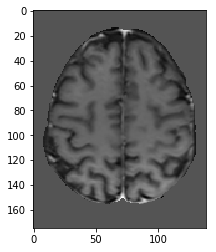

In [53]:
plt.imshow(patient_data[0,0,115,:,:], cmap='gray')

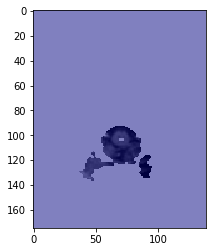

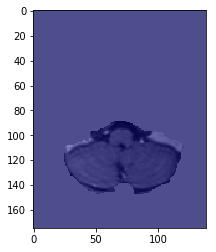

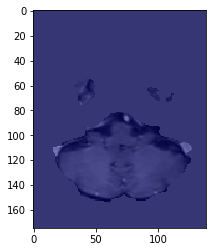

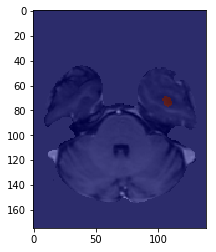

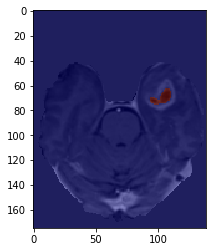

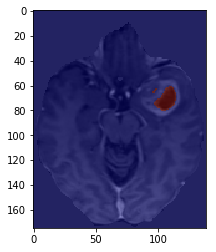

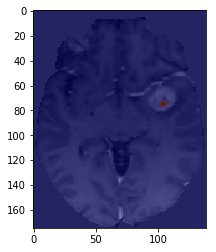

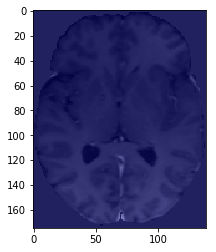

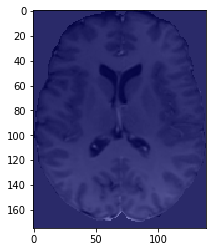

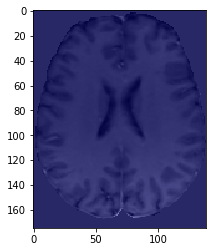

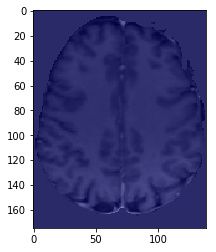

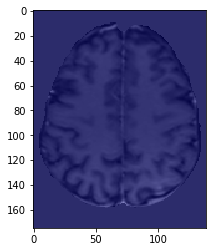

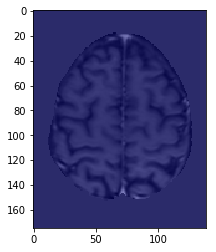

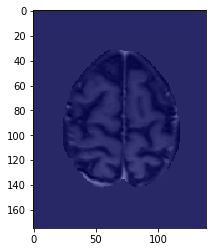

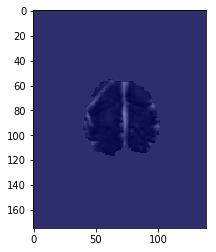

In [64]:
for i in np.arange(0, patient_data.shape[2], 10):
    plt.imshow(patient_data[0,0,i,:,:], cmap='gray')
    plt.imshow(np_cut[i], cmap='jet', alpha=0.5)
    plt.show()

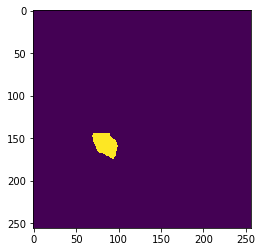

In [19]:
plt.imshow(np_prediction[0,0,75] > 0)